In [1]:
import sys
sys.path.append("../src")

import logging
from pathlib import Path
import numpy as np
import torch
from natsort import natsorted
from torch import nn
from matplotlib import pyplot as plt
from dataset.data_loading import BasicDataset
from dataset.dataset_interface import DatasetInterface
from networks.UNet.unet_model import UNet
import open3d as o3d
from utils.visualization_utils import visualize_depth, to_rgb
from utils.transformation_utils import imgs_to_pcd, rs_ci, unnormalize_depth
import yaml

root_path = Path("../")

class Args:
    trainer_id = "1646251505.7896235"
    model_dir = root_path / f"local_resources/models/{trainer_id}/M_total"

args = Args()

# following command copies the 
src_path = f"ng3916@bwunicluster.scc.kit.edu:~/self-supervised-depth-denoising/{args.model_dir.relative_to(root_path).parent}"
dest_path = args.model_dir.parent.parent
if not (Path(dest_path) / args.trainer_id).exists():
    !scp -r $src_path $dest_path

config_path = args.model_dir.parent / "config.yml"
model = natsorted(args.model_dir.glob("*.pth"), key=lambda f: f.stem.split('e')[1])[-1]
with open(config_path) as f:
    config = yaml.safe_load(f)

network_config = config['network_config']
trainer_config = config['basic_trainer']
dataset_config_yaml = config['dataset_config']
dataset_config = BasicDataset.Config.from_config(dataset_config_yaml)
network_config = {
    'name': 'M_total',
    'n_input_channels': dataset_config.num_in_channels(),
    'n_output_channels': 1,
    **network_config
}
unet_config = UNet.Config.from_config(network_config)

path = root_path / Path(trainer_config['train_path']).parent / "test_dataset.json"
logging.info(f"using path {path}")
files = DatasetInterface.get_files_by_path(path)
net = UNet(unet_config)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
logging.info(f'Loading model {model}')
logging.info(f'Using device {device}')

net.to(device=device)
net.load_state_dict(torch.load(model, map_location=device))
# fixes wrongly saved weights from data parallel
# tmp_net = nn.DataParallel(net)
# tmp_net.load_state_dict(torch.load(model, map_location=device))
# model.unlink()
# torch.save(tmp_net.module.state_dict(), model)
# net.load_state_dict(torch.load(model, Map_location=device))
net.eval()

logging.info('Model loaded!')

INFO - 2022-03-03 07:33:55,107 - 4293261048 - using path ../resources/images/calibrated_masked/not-cropped/ycb_video/test_dataset.json


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2022-03-03 07:33:55,120 - 4293261048 - Loading model ../local_resources/models/1646251505.7896235/M_total/e48.pth
INFO - 2022-03-03 07:33:55,120 - 4293261048 - Using device cpu
INFO - 2022-03-03 07:33:55,130 - 4293261048 - Model loaded!


INFO - 2022-03-03 07:33:55,251 - 3294447754 - 
Predicting image /home/claudiusk/Documents/Studium/KIT/Master/Semester_1/DL_Praktikum/self-supervised-depth-denoising/resources/images/calibrated_masked/not-cropped/ycb_video/10022022/1644491757.4790998.npz ...


51


/home/claudiusk/.conda/envs/depth-denoising_training/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
INFO - 2022-03-03 07:33:57,510 - 3294447754 - Mean depths: Input 867.3484223839167 Label 864.1133422851562 Predicted 862.8783569335938
INFO - 2022-03-03 07:33:57,510 - 3294447754 - Max depth difference : IT 91.33026123046875
INFO - 2022-03-03 07:33:57,521 - 3294447754 - Distance IT 12.564074287084352
INFO - 2022-03-03 07:33:57,528 - 3294447754 - Distance OT 7.552511066307508


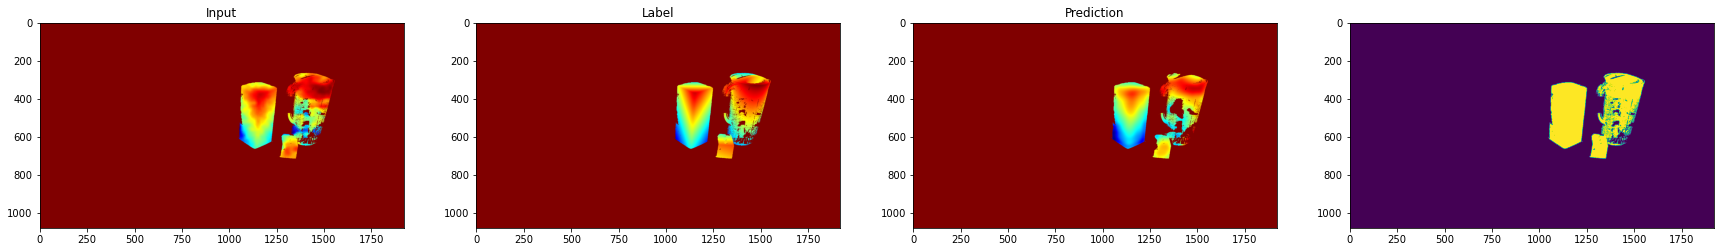

In [2]:
print(len(files))
idx = np.random.randint(len(files), size=1).item()
rs_rgb, rs_depth, zv_rgb, zv_depth, mask = DatasetInterface.load(files[idx])

logging.info(f'\nPredicting image {files[idx]} ...')

rs_min = np.nanmin(rs_depth)
rs_max = np.nanmax(rs_depth)

set = BasicDataset.preprocess_set(rs_rgb, rs_depth, mask, zv_depth, dataset_config)
img = set['image'].unsqueeze(0)
img = img.to(device=device, dtype=torch.float32)

with torch.no_grad() and torch.cuda.amp.autocast(enabled=network_config['amp']):
    pred_depths = net(img)
    pred_depth = pred_depths.squeeze().float().cpu().detach().numpy()

pred_depth = BasicDataset.postprocess_set(set, pred_depth, dataset_config)

# apply mask to input images
rs_depth = np.where(mask, rs_depth, np.nan)
zv_depth = np.where(mask, zv_depth, np.nan)

depth_difference = np.abs(rs_depth - zv_depth)
ot_depth_difference = np.abs(pred_depth - zv_depth)
max_depth_difference = np.nanmax(depth_difference)
logging.info(f"Mean depths: Input {np.nanmean(rs_depth)} Label {np.nanmean(zv_depth)} Predicted {np.nanmean(pred_depth)}")
logging.info(f"Max depth difference : IT {max_depth_difference}")
logging.info(f"Distance IT {np.nansum(np.abs(depth_difference))/ np.sum(mask)}")
logging.info(f"Distance OT {np.nansum(np.abs(zv_depth - pred_depth)) / np.sum(mask)}")

pred_pcd = imgs_to_pcd(rs_rgb, pred_depth, rs_ci)
input_depth_difference_pcd = imgs_to_pcd(((depth_difference / max_depth_difference) * 255).astype(np.uint8), rs_depth, rs_ci)
ot_depth_difference_pcd = imgs_to_pcd(((ot_depth_difference / np.nanmax(ot_depth_difference)) * 255).astype(np.uint8), rs_depth, rs_ci)
input_pcd = imgs_to_pcd(rs_rgb, rs_depth.astype(np.float32), rs_ci)
output_pcd = imgs_to_pcd(zv_rgb, zv_depth, rs_ci)

o3d.visualization.draw_geometries([input_pcd])
o3d.visualization.draw_geometries([output_pcd])
o3d.visualization.draw_geometries([input_depth_difference_pcd])
o3d.visualization.draw_geometries([ot_depth_difference_pcd])
o3d.visualization.draw_geometries([pred_pcd])
o3d.visualization.draw_geometries([input_pcd, output_pcd])
o3d.visualization.draw_geometries([input_pcd, pred_pcd])
o3d.visualization.draw_geometries([pred_pcd, output_pcd])

_, axarr = plt.subplots(1, 4, figsize=(30, 10))
axarr[0].title.set_text("Input")
axarr[0].imshow(visualize_depth(rs_depth))
axarr[1].title.set_text("Label")
axarr[1].imshow(visualize_depth(zv_depth))
axarr[2].title.set_text("Prediction")
axarr[2].imshow(visualize_depth(pred_depth))
axarr[3].imshow(mask)